In [1]:
import numpy as np
import xarray as xr
import dask
import xgcm
import zarr

In [2]:
# Define face_connections for grid object
face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}

### Load dataset

In [3]:
# Main disagnostic output
ds_main = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/eccov4r3_output')
coords_main = ds_main.coords.to_dataset().reset_coords()
ds_main = ds_main.reset_coords(drop=True)

# Budget terms
ds_budg = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/eccov4r3_budgets')
coords_budg = ds_budg.coords.to_dataset().reset_coords()
ds_budg = ds_budg.reset_coords(drop=True)

### Volume

In [4]:
# Cell z size
drF = coords_main.drF
rA = coords_main.rA
hFacC = coords_main.hFacC

# Volume (m^3)
vol = (rA*drF*hFacC).transpose('face','k','j','i')

In [5]:
#### Seperate averages and snapshots
ds_ave = ds_main[['ETAN','THETA','SALT','UVELMASS','VVELMASS','WVELMASS',
                  'ADVx_TH','ADVx_SLT','ADVy_TH','ADVy_SLT','ADVr_TH','ADVr_SLT']]

ds_snp = ds_main[['ETAN_snp','THETA_snp','SALT_snp']].rename({'time_snp':'time'})

In [6]:
# Remove oceFWflx from WVELMASS
WVELMASS = ds_main.WVELMASS.transpose('time','face','k_l','j','i')
oceFWflx = ds_main.oceFWflx.assign_coords(k_l=0).expand_dims('k_l').transpose('time','face','k_l','j','i')

rhoconst = 1029
oceFWflx = (oceFWflx/rhoconst)
WVELMASS = xr.concat([WVELMASS.sel(k_l=0) + oceFWflx, WVELMASS[:,:,1:]], 
                     dim='k_l').transpose('time','face','k_l','j','i')

In [7]:
#### Monthly means
ds_ave_clim = ds_ave.groupby('time.month').mean('time')
WVELMASS_clim = WVELMASS.groupby('time.month').mean('time')
ds_snp_clim = ds_snp.groupby('time.month').mean('time')
ds_budg_clim = ds_budg.groupby('time.month').mean('time')

#### Monthly anomalies
ds_ave_anom = ds_ave.groupby('time.month') - ds_ave_clim
WVELMASS_anom = WVELMASS.groupby('time.month') - WVELMASS_clim
ds_snp_anom = ds_snp.groupby('time.month') - ds_snp_clim
ds_budg_anom = ds_budg.groupby('time.month') - ds_budg_clim

In [8]:
#### Monthly mean terms
grid = xgcm.Grid(ds_ave_clim, face_connections=face_connections)

# Transport
u_clim = (ds_ave_clim.UVELMASS * coords_main.dyG * coords_main.drF).transpose('month','face','k','j','i_g')
v_clim = (ds_ave_clim.VVELMASS * coords_main.dxG * coords_main.drF).transpose('month','face','k','j_g','i')
w_clim = (WVELMASS_clim * coords_main.rA).transpose('month','face','k_l','j','i')

# Potential Temperature (degC)
THETA_clim = ds_ave_clim.THETA.transpose('month','face','k','j','i')
THETA_clim_at_u = grid.interp(THETA_clim, 'X', boundary='extend')
THETA_clim_at_v = grid.interp(THETA_clim, 'Y', boundary='extend')
THETA_clim_at_w = grid.interp(THETA_clim, 'Z', boundary='extend')

In [9]:
#### Monthly anomaly terms
grid = xgcm.Grid(ds_ave_anom, face_connections=face_connections)

# Transport
u_anom = (ds_ave_anom.UVELMASS * coords_main.dyG * coords_main.drF).transpose('time','face','k','j','i_g')
v_anom = (ds_ave_anom.VVELMASS * coords_main.dxG * coords_main.drF).transpose('time','face','k','j_g','i')
w_anom = (WVELMASS_anom * coords_main.rA).transpose('time','face','k_l','j','i')

# Temperature
THETA_anom = ds_ave_anom.THETA.transpose('time','face','k','j','i')
THETA_anom_at_u = grid.interp(THETA_anom, 'X', boundary='extend')
THETA_anom_at_v = grid.interp(THETA_anom, 'Y', boundary='extend')
THETA_anom_at_w = grid.interp(THETA_anom, 'Z', boundary='extend')

### Monthly anomaly budget
$$\frac{\partial\theta^{\prime}}{\partial t} + \overline{\bf{u}}^m\cdot\nabla\theta^{\prime} + \bf{u}^{\prime} \cdot \overline{\nabla\theta}^m -\nabla \cdot ({\bf{u}}^{\prime}\,\theta^{\prime}-\overline{\bf{u}^{\prime}\,\theta^{\prime}}^m) = -\nabla \cdot {\bf{F_{diff}}}^{\prime} - F_{\textrm{forc}}^{\prime}$$

$\overline{\bf{u}}^m\cdot\nabla\theta^{\prime}$

In [10]:
#### Mean advection of anomaleous temperature
uclimTanom = u_clim * THETA_anom_at_u.groupby('time.month')
vclimTanom = v_clim * THETA_anom_at_v.groupby('time.month')
wclimTanom = w_clim * THETA_anom_at_w.groupby('time.month')

# Convergence
ADVxy_diff = grid.diff_2d_vector({'X' : uclimTanom, 'Y' : vclimTanom}, boundary = 'fill')
ADVx_diffx = ADVxy_diff['X']
ADVy_diffy = ADVxy_diff['Y']
adv_hConvH_Uclim_Tanom = (-(ADVx_diffx + ADVy_diffy)/vol)
adv_vConvH_Uclim_Tanom = (grid.diff(wclimTanom, 'Z', boundary='fill')/vol)

adv_ConvH_Uclim_Tanom = adv_hConvH_Uclim_Tanom + adv_vConvH_Uclim_Tanom

$\bf{u}^{\prime} \cdot \overline{\nabla\theta}^m$

In [11]:
#### Anomaleous advection of mean temperature
uanomTclim = u_anom.groupby('time.month') * THETA_clim_at_u
vanomTclim = v_anom.groupby('time.month') * THETA_clim_at_v
wanomTclim = w_anom.groupby('time.month') * THETA_clim_at_w

# Convergence
ADVxy_diff = grid.diff_2d_vector({'X' : uanomTclim, 'Y' : vanomTclim}, boundary = 'fill')
ADVx_diffx = ADVxy_diff['X']
ADVy_diffy = ADVxy_diff['Y']
adv_hConvH_Uanom_Tclim = (-(ADVx_diffx + ADVy_diffy)/vol)
adv_vConvH_Uanom_Tclim = (grid.diff(wanomTclim, 'Z', boundary='fill')/vol)

adv_ConvH_Uanom_Tclim = adv_hConvH_Uanom_Tclim + adv_vConvH_Uanom_Tclim

/rigel/home/jt2796/dask/dask/array/core.py:3460: PerformanceWarning: Increasing number of chunks by factor of 24
  **atop_kwargs)
/rigel/home/jt2796/dask/dask/array/core.py:3460: PerformanceWarning: Increasing number of chunks by factor of 24
  **atop_kwargs)
/rigel/home/jt2796/dask/dask/array/core.py:3460: PerformanceWarning: Increasing number of chunks by factor of 24
  **atop_kwargs)
/rigel/home/jt2796/dask/dask/array/core.py:3460: PerformanceWarning: Increasing number of chunks by factor of 24
  **atop_kwargs)
/rigel/home/jt2796/dask/dask/array/core.py:3460: PerformanceWarning: Increasing number of chunks by factor of 24
  **atop_kwargs)
/rigel/home/jt2796/dask/dask/array/core.py:3460: PerformanceWarning: Increasing number of chunks by factor of 24
  **atop_kwargs)
/rigel/home/jt2796/dask/dask/array/core.py:3460: PerformanceWarning: Increasing number of chunks by factor of 24
  **atop_kwargs)
/rigel/home/jt2796/dask/dask/array/core.py:3460: PerformanceWarning: Increasing number of 

$\nabla \cdot ({\bf{u}}^{\prime}\,\theta^{\prime}-\overline{\bf{u}^{\prime}\,\theta^{\prime}}^m)$

In [12]:
#### Anomaleous advection of anomaleous temperature
uanomTanom = u_anom * THETA_anom_at_u
vanomTanom = v_anom * THETA_anom_at_v
wanomTanom = w_anom * THETA_anom_at_w

uanomTanom_clim = uanomTanom.groupby('time.month').mean('time')
vanomTanom_clim = vanomTanom.groupby('time.month').mean('time')
wanomTanom_clim = wanomTanom.groupby('time.month').mean('time')

uanomTanom_clim_anom = uanomTanom.groupby('time.month') - uanomTanom_clim
vanomTanom_clim_anom = vanomTanom.groupby('time.month') - vanomTanom_clim
wanomTanom_clim_anom = wanomTanom.groupby('time.month') - wanomTanom_clim

# Convergence
ADVxy_diff = grid.diff_2d_vector({'X' : uanomTanom_clim_anom, 'Y' : vanomTanom_clim_anom}, boundary = 'fill')
ADVx_diffx = ADVxy_diff['X']
ADVy_diffy = ADVxy_diff['Y']
adv_hConvH_Uanom_Tanom = (-(ADVx_diffx + ADVy_diffy)/vol)
adv_vConvH_Uanom_Tanom = (grid.diff(wanomTanom_clim_anom, 'Z', boundary='fill')/vol)

adv_ConvH_Uanom_Tanom = adv_hConvH_Uanom_Tanom + adv_vConvH_Uanom_Tanom

In [13]:
#### Residual in the advective flux

# Transport
u_transport = (ds_ave.UVELMASS * coords_main.dyG * coords_main.drF)
v_transport = (ds_ave.VVELMASS * coords_main.dxG * coords_main.drF)
w_transport = (WVELMASS * rA)

# Temperature
THETA = ds_main.THETA
THETA_at_u = grid.interp(THETA, 'X', boundary='extend')
THETA_at_v = grid.interp(THETA, 'Y', boundary='extend')
THETA_at_w = grid.interp(THETA, 'Z', boundary='extend')

# Advection
uT = (u_transport * THETA_at_u)
vT = (v_transport * THETA_at_v)
wT = (w_transport * THETA_at_w)

# Convergence
ADVxy_diff = grid.diff_2d_vector({'X' : uT, 'Y' : vT}, boundary = 'fill')
ADVx_diffx = ADVxy_diff['X']
ADVy_diffy = ADVxy_diff['Y']
adv_hConvH = (-(ADVx_diffx + ADVy_diffy)/vol).transpose('time','face','k','j','i')
adv_vConvH = (grid.diff(wT, 'Z', boundary='fill')/vol).transpose('time','face','k','j','i')

# Reconstructed
adv_ConvH_reco = adv_hConvH + adv_vConvH

# True (diagnostic)
adv_ConvH_true = ds_budg.adv_hConvH + ds_budg.adv_vConvH

# Residual
adv_ConvH_res = adv_ConvH_true - adv_ConvH_reco
adv_ConvH_res_clim = adv_ConvH_res.groupby('time.month').mean('time')
adv_ConvH_res_anom = adv_ConvH_res.groupby('time.month') - adv_ConvH_res_clim

### Save dataset

In [14]:
ds = xr.Dataset(data_vars={})

# Tendency
ds['tnd'] = ds_budg_anom.tendH

# Forcing
ds['frc'] = ds_budg_anom.forcH

# Mixing
ds['hdif'] = ds_budg_anom.dif_hConvH
ds['vdif'] = ds_budg_anom.dif_vConvH

# Advection (Ubar Tprime)
ds['hadv_Uclim_Tanom'] = adv_hConvH_Uclim_Tanom
ds['vadv_Uclim_Tanom'] = adv_vConvH_Uclim_Tanom

# Advection (Uprime Tbar)
ds['hadv_Uanom_Tclim'] = adv_hConvH_Uanom_Tclim
ds['vadv_Uanom_Tclim'] = adv_vConvH_Uanom_Tclim

# Advection (Uprime Tprime)
ds['hadv_Uanom_Tanom'] = adv_hConvH_Uanom_Tanom
ds['vadv_Uanom_Tanom'] = adv_vConvH_Uanom_Tanom

# Residual
ds['res'] = adv_ConvH_res_anom

In [15]:
ds

<xarray.Dataset>
Dimensions:           (face: 13, i: 90, j: 90, k: 50, time: 288)
Coordinates:
  * face              (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i                 (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                 (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * k                 (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * time              (time) datetime64[ns] 1992-01-15 1992-02-13 1992-03-15 ...
    month             (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 ...
Data variables:
    tnd               (time, face, k, j, i) float64 dask.array<shape=(288, 13, 50, 90, 90), chunksize=(1, 13, 50, 90, 90)>
    frc               (time, face, k, j, i) float64 dask.array<shape=(288, 13, 50, 90, 90), chunksize=(1, 13, 50, 90, 90)>
    hdif              (time, face, k, j, i) float32 dask.array<shape=(288, 13, 50, 90, 90), chunksize=(1, 13, 50, 90, 90)>
    vdif              (time, face, k, j, i) float32 das

### Save to zarr

In [16]:
for varname in ds.data_vars:
    ds[varname] = ds[varname].chunk(chunks={'time':1,'face':13,'k':50,'j':90,'i':90})

In [17]:
zarr.blosc.list_compressors()

['blosclz', 'lz4', 'lz4hc', 'snappy', 'zlib', 'zstd']

In [18]:
compressor = zarr.Blosc(cname='zlib')
opts = {}
for varname in ds.data_vars:
    opts[varname] = {'compressor': compressor, 'chunks': (1, 13, 50, 90, 90)}

In [19]:
ds

<xarray.Dataset>
Dimensions:           (face: 13, i: 90, j: 90, k: 50, time: 288)
Coordinates:
  * face              (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i                 (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                 (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * k                 (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * time              (time) datetime64[ns] 1992-01-15 1992-02-13 1992-03-15 ...
    month             (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 ...
Data variables:
    tnd               (time, face, k, j, i) float64 dask.array<shape=(288, 13, 50, 90, 90), chunksize=(1, 13, 50, 90, 90)>
    frc               (time, face, k, j, i) float64 dask.array<shape=(288, 13, 50, 90, 90), chunksize=(1, 13, 50, 90, 90)>
    hdif              (time, face, k, j, i) float32 dask.array<shape=(288, 13, 50, 90, 90), chunksize=(1, 13, 50, 90, 90)>
    vdif              (time, face, k, j, i) float32 das

In [20]:
from dask.diagnostics import ProgressBar

In [21]:
with ProgressBar():
    ds.to_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/anom/budgH', encoding=opts)

[                                        ] | 0% Completed |  3min 35.7s

/rigel/home/jt2796/dask/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/rigel/home/jt2796/dask/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[#                                       ] | 4% Completed |  7min 42.2s

/rigel/home/jt2796/dask/dask/local.py:255: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/rigel/home/jt2796/dask/dask/local.py:255: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)


[########################################] | 100% Completed | 59min 42.2s


### Check

In [22]:
ds_budgH_anom = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/anom/budgH')

In [23]:
ds_budgH_anom

<xarray.Dataset>
Dimensions:           (face: 13, i: 90, j: 90, k: 50, time: 288)
Coordinates:
  * face              (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i                 (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * j                 (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * k                 (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
    month             (time) int64 dask.array<shape=(288,), chunksize=(288,)>
  * time              (time) datetime64[ns] 1992-01-15 1992-02-13 1992-03-15 ...
Data variables:
    frc               (time, face, k, j, i) float64 dask.array<shape=(288, 13, 50, 90, 90), chunksize=(1, 13, 50, 90, 90)>
    hadv_Uanom_Tanom  (time, face, k, j, i) float32 dask.array<shape=(288, 13, 50, 90, 90), chunksize=(1, 13, 50, 90, 90)>
    hadv_Uanom_Tclim  (time, face, k, j, i) float32 dask.array<shape=(288, 13, 50, 90, 90), chunksize=(1, 13, 50, 90, 90)>
    hadv_Uclim_Tanom  (time, face, k, j, i) float32 dask.

### Plot time series

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
f = 1
k = 1
j = 10
i = 10

In [26]:
results = dask.compute(ds_budgH_anom.tnd[:,f,k,j,i],
                       ds_budgH_anom.frc[:,f,k,j,i], 
                       ds_budgH_anom.hdif[:,f,k,j,i],
                       ds_budgH_anom.vdif[:,f,k,j,i],
                       ds_budgH_anom.hadv_Uclim_Tanom[:,f,k,j,i], 
                       ds_budgH_anom.vadv_Uclim_Tanom[:,f,k,j,i],
                       ds_budgH_anom.hadv_Uanom_Tclim[:,f,k,j,i],
                       ds_budgH_anom.vadv_Uanom_Tclim[:,f,k,j,i],
                       ds_budgH_anom.hadv_Uanom_Tanom[:,f,k,j,i],
                       ds_budgH_anom.vadv_Uanom_Tanom[:,f,k,j,i],
                       ds_budgH_anom.res[:,f,k,j,i])

$$\frac{\partial\theta^{\prime}}{\partial t} + \overline{\bf{u}}^m\cdot\nabla\theta^{\prime} + \bf{u}^{\prime} \cdot \overline{\nabla\theta}^m -\nabla \cdot ({\bf{u}}^{\prime}\,\theta^{\prime}-\overline{\bf{u}^{\prime}\,\theta^{\prime}}^m) = -\nabla \cdot {\bf{F_{diff}}}^{\prime} - F_{\textrm{forc}}^{\prime}$$
- `results[0]`: anomaleous tendency ($\frac{\partial\theta^{\prime}}{\partial t}$)
- `results[1]`: anomaleous forcing ($F_{\textrm{forc}}^{\prime}$)
- `results[2]`: anomaleous horizontal diffusion ($\nabla_h \cdot {\bf{F_{diff}}}^{\prime}$)
- `results[3]`: anomaleous vertical diffusion ($\frac{\partial}{\partial z}{\bf{F_{diff}}}^{\prime}$)

- `results[4-5]`: mean advection of T anomalies ($\overline{\bf{u}}^m\cdot\nabla\theta^{\prime}$)
- `results[6-7]`: anomaleous advection of mean T ($\bf{u}^{\prime} \cdot \overline{\nabla\theta}^m$)
- `results[8-9]`: $\nabla \cdot ({\bf{u}}^{\prime}\,\theta^{\prime}-\overline{\bf{u}^{\prime}\,\theta^{\prime}}^m)$
- `results[10]`: residual

In [27]:
total = results[1] + results[2] + results[3] + results[4] + results[5] + results[6] + results[7] + results[8] + results[9] + results[10]

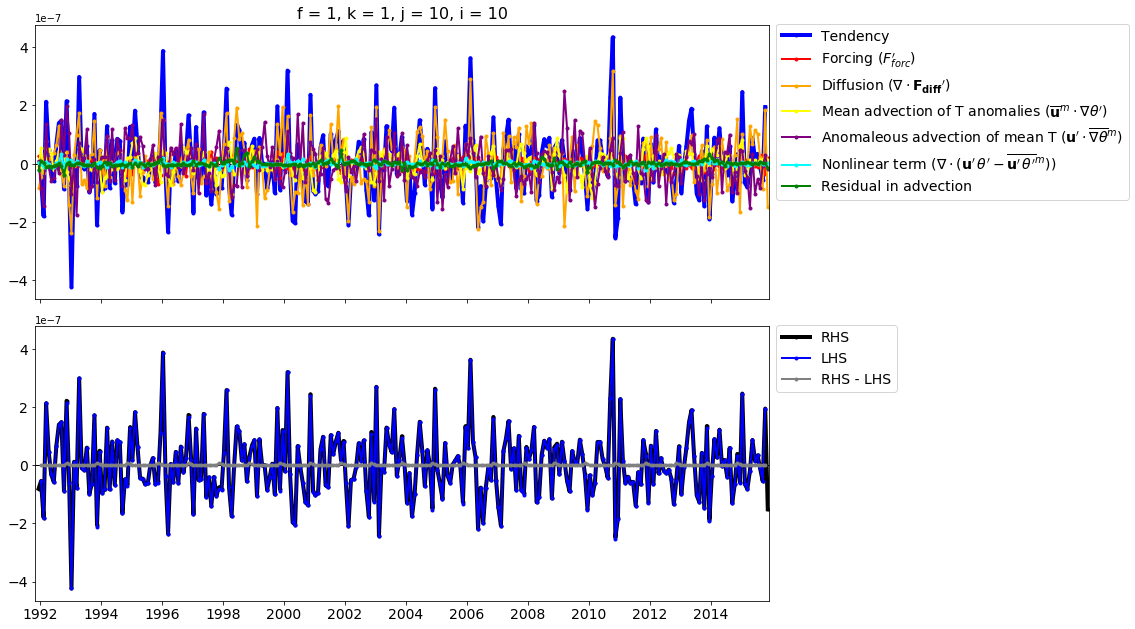

In [29]:
fig, axes = plt.subplots(2, 1,figsize=(17,10))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.title('f = %s, k = %s, j = %s, i = %s' % (f,k,j,i), fontsize=16)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time, results[0], lw=4, color='blue', marker='.',label='Tendency')
plt.plot(results[1].time, results[1], lw=2, color='red', marker='.',
         label=r'Forcing ($F_{forc}^{\prime}$)')
plt.plot(results[2].time, results[2]+results[3], lw=2, color='orange', marker='.',
         label=r'Diffusion ($\nabla \cdot {\mathbf{F_{diff}}}^{\prime}$)')
plt.plot(results[3].time, results[4]+results[5], lw=2, color='yellow', marker='.',
         label=r'Mean advection of T anomalies ($\overline{\mathbf{u}}^m\cdot\nabla\theta^{\prime}$)')
plt.plot(results[4].time, results[6]+results[7], lw=2, color='purple', marker='.',
         label=r'Anomaleous advection of mean T ($\mathbf{u}^{\prime} \cdot \overline{\nabla\theta}^m$)')
plt.plot(results[5].time, results[8]+results[9], lw=2, color='cyan', marker='.',
         label=r'Nonlinear term ($\nabla \cdot ({\mathbf{u}}^{\prime}\,\theta^{\prime}-\overline{\mathbf{u}^{\prime}\,\theta^{\prime}}^m)$)')
plt.plot(results[6].time, results[10], lw=2, color='green', marker='.',label='Residual in advection')
#plt.xlim([ds_budgH_anom.time.values[0],ds_budgH_anom.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'))
plt.yticks(np.arange(-4e-7,6e-7,2.0e-7),fontsize=14)
plt.setp(plt.gca(), 'xticklabels',[])
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

plt.subplot(2, 1, 2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(total.time, total, lw=4, color='k', marker='.',label='RHS')
plt.plot(results[0].time, results[0], lw=2, color='blue', marker='.',label='LHS')
plt.plot(results[0].time, total-results[0], lw=2, color='grey', marker='.',label='RHS - LHS')
#plt.xlim([ds_budgH_anom.time.values[0],ds_budgH_anom.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'),fontsize=14)
plt.yticks(np.arange(-4e-7,6e-7,2.0e-7),fontsize=14)

plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

fig.subplots_adjust(left=0.1, right=0.7, bottom=0.1, top=0.9)

#plt.savefig('/rigel/home/jt2796/tmp/figure.png')
plt.show()